<a href="https://colab.research.google.com/github/jkroberts1/CS598_DLH-Spring24-Group47/blob/main/CS_598_DLH_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/CS598_DLH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS598_DLH


# Introduction
There are many previous studies that support the claim that anticancer drug sensitivity in cell
lines are not tissue-specific, because of this tissue-specific drugs can be of benefit to other
tissues. This project aims to develop a drug synergy prediction model for understudied tissues in
an attempt to overcome data scarcity (Kim et al, 2021). With this synergy prediction model we
can rank synergistic drug combinations in understudied tissues.

This problem is a data processing problem for diseases. There is simply not enough data available to be processed for cancer in areas that are hard to perform medical analysis on. Therefore what this paper aims to do is, using drugs that work well on a given tissue in the body, predict the effectiveness on the drug on a different yet similar tissue in the body. Medical study already indicates what kinds of tissue are similar to highly studied tissues and in what ways they are similar.

The innovations of the paper is that this will not only overcome the challenge of not having enough data on tissues that get cancer, once successful this will add to the data on those tissues. Therefore this project works to single-handedly solve the issues surrounding data-poor tissues.

The paper reports it's own accuracy as follows: "Our drug response prediction model was able to successfully bypass the posttreatment features while achieving competitive accuracy (Kim et al, 2021)". It's major contribution to the research regime is the transfer of learning between data-rich and data-poor in-silico experiments. Outside of the goals of the model there is much to be said about how this paper sets a precedent for future papers to tackle harder to experiment parts of the body.


# Scope of Reproducibility

The hypothesis we will test from the paper in this project is as follows

1.   If a model is trained to predict drug effectiveness on
well studied tissues, then that model can be transferred to a “student” model trained on
understudied tissues while retaining drug effectiveness prediction accuracy.

What this hypothesis is stating is a direct overview of the goals of the paper and project. The
project is aiming to build a model that aims to show a direct synergy between well studied and
understudied tissues and how effective drugs are on them.

This is feasible because we know from previous studies that cancer medication does not show higher efficacy in targeted cell lines (Jaeger et al., 2015). To improve the performance of training
with tissues that don’t have as much data we can use transfer learning where we build a teacher
model that utilizes the well suited data and then transfers those output parameters as inputs to a
model with less data.

We aim to reproduce the results of the paper and then also perform ablations on the model to test it's resiliency. We will be using the original code in order to replicate the results of the project and then test out the ablations and any improvements.



# NOTE

To gain access to the input data in an easy way you can check the references [5] source which is data from the author of the paper.

**LINK TO GITHUB REPO**
https://github.com/jkroberts1/CS598_DLH-Spring24-Group47.git

# Methodology

##Data Preprocessing (1)

The following section(s) will go over the data that we use and load into the model. It will cover the datasets we use, and what we gain from them.

First we start with the DrugComb data which can be accessed here:
https://drugcomb.fimm.fi/

This dataset has records on 4150 drugs and 112 cell lines. We show a description of the data set with the .head() command.

Refer to comments in the code to see how the data is manipulated.

In [ ]:
%pip install matplotlib --
%pip install rdkit

import pandas as pd
import numpy as np
import pickle
from utilities import Mapping

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys

import re

import seaborn as sns
from matplotlib.colors import LogNorm
import math

data_path=''
external_data_path=''

summary=pd.read_csv(data_path+'summary_v_1_5.csv')
#Block to StudyID mapping
source=pd.read_csv(data_path+'source.csv')

# Create a dictionary mapping study names to study IDs
study_id_map = dict(zip(source['sname'], source['id']))

# Add a new column 'study_id' to summary based on the mapping
summary['study_id'] = summary['study_name'].map(study_id_map)

summary_study = summary.sort_values(by='block_id')

summary_study.head()


<ipython-input-6-509cea09a82d>:26: DtypeWarning: Columns (2,7,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  summary=pd.read_csv(data_path+'summary_v_1_5.csv')


,block_id,drug_row,drug_col,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,ic50_row,ic50_col,...,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name,study_id
1012548,1,5-Fluorouracil,Veliparib,A2058,ONEIL,skin,uM,uM,5.126836,3.267734,...,19.398,3.865915,-2.951386,5.536903,6.256584,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...,1
1012549,2,5-Fluorouracil,Veliparib,A2058,ONEIL,skin,uM,uM,5.126836,3.267734,...,15.989,8.247403,3.125927,11.614215,12.333896,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...,1
1012550,3,5-Fluorouracil,Veliparib,A2058,ONEIL,skin,uM,uM,5.126836,3.267734,...,18.430,6.063440,2.452239,10.940528,11.660209,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...,1
1012551,4,5-Fluorouracil,Veliparib,A2058,ONEIL,skin,uM,uM,5.126836,3.267734,...,12.545,-4.280231,-4.062761,4.425528,5.145209,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...,1
1012552,5,5-Fluorouracil,MK-1775,A2058,ONEIL,skin,uM,uM,5.126836,0.266027,...,41.683,12.284698,10.409407,18.656340,15.765467,4,2,Prelamin-A/C; Survival motor neuron protein; T...,Serine/threonine-protein kinase TBK1; Protein ...,1


In [ ]:
columns_to_convert = ['ri_row', 'ri_col', 'synergy_loewe']

# Convert columns to numeric, coercing errors to NaN
for column in columns_to_convert:
    summary_study[column] = pd.to_numeric(summary_study[column], errors='coerce')
print(summary_study['study_name'])
# Now perform the aggregation
summary_mean = summary_study.groupby(['drug_row', 'drug_col', 'cell_line_name', 'study_id', 'study_name', 'tissue_name'], as_index=False).agg({
    'ri_row': 'mean',
    'ri_col': 'mean',
    'synergy_loewe': 'mean'
})

1012548              ONEIL
1012549              ONEIL
1012550              ONEIL
1012551              ONEIL
1012552              ONEIL
                ...       
1340664    FALLAHI-SICHANI
1239920    FALLAHI-SICHANI
1029483    FALLAHI-SICHANI
1340665    FALLAHI-SICHANI
1239921    FALLAHI-SICHANI
Name: study_name, Length: 1432351, dtype: object


Text(0, 0.5, 'counts')

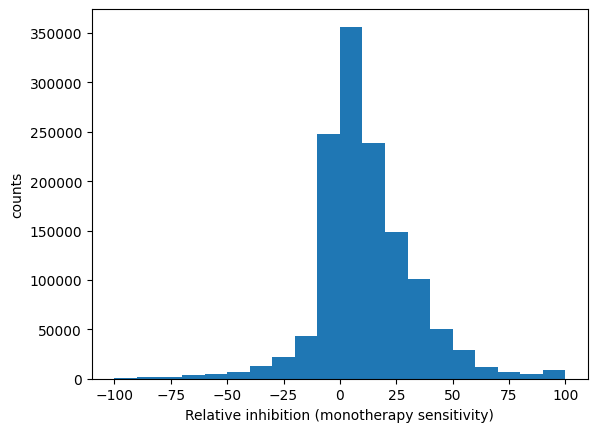

In [ ]:

sensitivity=pd.concat([summary_mean.loc[:, ['drug_row', 'cell_line_name', 'ri_row']].rename(columns={'drug_row':'drug', 'ri_row':'ri'}),
          summary_mean.loc[:, ['drug_col', 'cell_line_name', 'ri_col']].rename(columns={'drug_col':'drug', 'ri_col':'ri'})])


plt.hist(sensitivity['ri'], bins=20, range=[-100,100])
plt.xlabel("Relative inhibition (monotherapy sensitivity)")
plt.ylabel("counts")
#plt.savefig(data_path+'ri_cnt.png',  bbox_inches='tight', dpi=200)

Text(0, 0.5, 'counts')

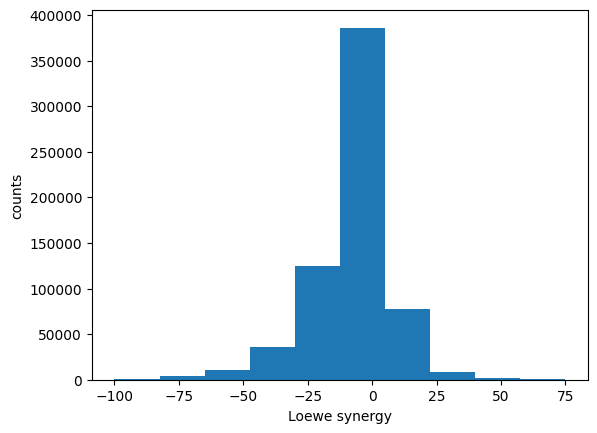

In [ ]:
plt.hist(((summary_mean.loc[:,'synergy_loewe'].values.reshape(-1))), range=[-100, 75])
plt.xlabel("Loewe synergy")
plt.ylabel("counts")
#plt.savefig(data_path+'syn_cnt.png', bbox_inches='tight', dpi=200)

/usr/local/lib/python3.10/dist-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


(-100.0, 100.0)

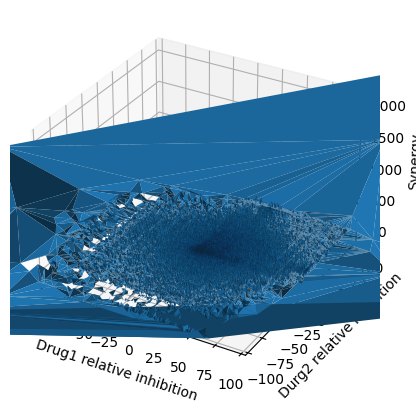

In [ ]:
X=summary_mean.loc[:,'ri_row'].to_numpy()
Y=summary_mean.loc[:,'ri_col'].to_numpy()
Z=summary_mean.loc[:,'synergy_loewe'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_trisurf(X,Y,Z)

ax.set_xlabel('Drug1 relative inhibition')
ax.set_ylabel('Durg2 relative inhibition')
ax.set_zlabel('Synergy')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
#fig.savefig(data_path+'ri_synergy_3d.png', dpi=200)

In [ ]:
codes={'drugs': Mapping(set(summary_mean['drug_row'].unique()).union(set(summary_mean['drug_col'].unique()))),
      'cell':Mapping(summary_mean['cell_line_name'].unique())}

In [ ]:
summary_mean['drug_col']=summary_mean['drug_col'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['drug_row']=summary_mean['drug_row'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['cell_line_name']=summary_mean['cell_line_name'].apply(lambda x: codes['cell'].item2idx[x])

In [ ]:
summary_mean.head()


,drug_row,drug_col,cell_line_name,study_id,study_name,tissue_name,ri_row,ri_col,synergy_loewe
0,367,3900,0,4,FORCINA,brain,-21.079400,17.392589,4.436431
1,3365,323,1,6,MATHEWS,haematopoietic_and_lymphoid,-20.043000,25.595000,-44.555935
2,3365,1798,1,6,MATHEWS,haematopoietic_and_lymphoid,-9.776000,29.111000,-37.189720
3,3622,3900,0,4,FORCINA,brain,-4.051616,17.392589,10.755529
4,2166,464,2,8,NCATS_ES(FAKI/AURKI),bone,1.966000,25.537000,-8.644502


In [ ]:
summary_mean.to_pickle(data_path+'summary_mean.p')


## Data Preprocessing (2)
### **Drug's molescule structure**

This data comes from SMILES. This is a linear notation to express the chemical compounds in a unique manner. The data can be accessed here:
https://www.dna.bio.keio.ac.jp/smiles/

This will be used in the language processing model called Transformer to encode the sequences.

In [ ]:
#FILTERING and ERROR CORRECTION
drug=pd.read_csv(data_path+'drug.csv')
drug.drop('id', axis=1, inplace=True)
drug['id']=drug['dname'].apply(lambda x: codes['drugs'].item2idx.get(x))
drug=drug.loc[~drug['id'].isna(),:]

drug.loc[drug['cid']==57519530,'smiles']='CC(C)CC1C(=O)NC(C(=O)NC(CCCC=CCCCCCCC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N1)CCCNC(=N)N)CC2=CNC3=CC=CC=C32)CC(C)C)CC(=O)N)(C)NC(=O)C(CC4=CC=CC=C4)NC(=O)C(C(C)O)NC(=O)C(CCC(=O)N)NC(=O)C(CCC(=O)N)NC(=O)C(CO)NC(=O)C(CCC(=O)N)NC(=O)CCNC(=O)C)(C)C(=O)NC(CCC(=O)N)C(=O)NC(CC(=O)N)C(=O)N)CC(C)C'
drug.loc[drug['cid']==73265323,'smiles']='CC(C)CCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'
drug.loc[drug['cid']==16131923,'smiles']='CCCCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'

drug.to_csv(data_path+'drug_clean.csv',index=False)

In [ ]:
#GET MACCS FINGERPRINT
drug=pd.read_csv(data_path+'drug_clean.csv')
drug['fps'] = drug['smiles'].apply(lambda x: list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x.replace("\\", "").replace(";","")))) if isinstance(x, str) and Chem.MolFromSmiles(x.replace("\\", "").replace(";","")) is not None else [])

drug.to_pickle(data_path+'drug_clean_fp.p')

[02:07:04] SMILES Parse Error: syntax error while parsing: Antibody
[02:07:04] SMILES Parse Error: Failed parsing SMILES 'Antibody' for input: 'Antibody'
[02:07:05] Explicit valence for atom # 34 F, 2, is greater than permitted
[02:07:05] Explicit valence for atom # 31 N, 6, is greater than permitted


In [ ]:
drug=pickle.load(open(data_path+'drug_clean_fp.p', 'rb'))
drug['id']=drug['id'].apply(lambda x: int(x))

In [ ]:
drug

,dname,chembl_id,inchikey,smiles,cid,molecular_formula,clinical_phase,cid_m,cid_s,stitch_name,drugbank_id,kegg_id,synonyms,target_name,target_type,id,fps
0,5-Fluorouracil,CHEMBL185,GHASVSINZRGABV-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)F,3385.0,C4H3FN2O2,4.0,CIDm00003385,CIDs00003385,5-fluorouracil,DB00544,D00584,5-Fluorouracil; fluorouracil; 51-21-8; 5-FU; F...,Prelamin-A\/C; Survival motor neuron protein; ...,single protein; nucleic acid,1601,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Veliparib,CHEMBL506871,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,11960529.0,C13H16N4O,3.0,CIDm11842604,CIDs11960529,veliparib,DB07232,D09692,Veliparib; 912444-00-9; ABT-888; ABT 888; ABT-...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...,single protein; protein family,1870,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MK-1775,CHEMBL1976040,BKWJAKQVGHWELA-UHFFFAOYSA-N,CC(C)(C1=NC(=CC=C1)N2C3=NC(=NC=C3C(=O)N2CC=C)N...,24856436.0,C27H32N8O2,2.0,CIDm24856436,CIDs24856436,MK-1775,DB11740,NaN,MK-1775; 955365-80-7; Adavosertib; MK1775; MK ...,Serine\/threonine-protein kinase TBK1; Protein...,single protein,1391,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,915019-65-7,CHEMBL1879463,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,11977753.0,C30H23N5O,2.0,CIDm11977753,CIDs11977753,NVP-BEZ235,DB11651,D10552,915019-65-7; dactolisib; NVP-BEZ235; BEZ235; N...,ALK tyrosine kinase receptor; Macrophage colon...,single protein; protein complex; protein compl...,2129,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Bortezomib,CHEMBL325041,GXJABQQUPOEUTA-RDJZCZTQSA-N,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0,C19H25BN4O4,4.0,CIDm00093860,CIDs00387447,bortezomib,DB00188,D03150,Bortezomib; 179324-69-7; Velcade; PS-341; LDP-...,Cathepsin G; Beta-chymotrypsin; Proteasome sub...,single protein; protein complex group; protein...,1011,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,Acifluorfen,CHEMBL222440; CHEMBL222440,NUFNQYOELLVIPL-UHFFFAOYSA-N,C1=CC(=C(C=C1C(F)(F)F)Cl)OC2=CC(=C(C=C2)[N+](=...,44073.0,C14H7ClF3NO5,0.0,CIDm00044072,CIDs00044072,acifluorfen,DB07338,NaN,Acifluorfen; 50594-66-6; Acifluorfene; Acifluo...,"Protoporphyrinogen oxidase, mitochondrial; Pro...",single protein,89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4368,Cephaeline Hydrobromide,CHEMBL581886; CHEMBL581886,IMINJYRRSNHIAA-QJAXAJGISA-N,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,45489168.0,C28H39BrN2O4,0.0,CIDm00002665,CIDs00442195,cephaeline,NaN,NaN,Cephaeline Hydrobromide; GNF-Pf-307; CHEMBL581...,NaN,NaN,1013,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4369,Z-FA-fluoromethyl ketone,CHEMBL2402203; CHEMBL2402203,ASXVEBPEZMSPHB-YJBOKZPZSA-N,CC(C(=O)CF)NC(=O)C(CC1=CC=CC=C1)NC(=O)OCC2=CC=...,5311161.0,C21H23FN2O4,0.0,CIDm00122019,CIDs05311161,cathepsin B inhibitor,NaN,NaN,Z-FA-fluoromethyl ketone; Z-FA-FMK; 105637-38-...,NaN,NaN,4151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4370,GS-441524,CHEMBL2016757; CHEMBL2016757,BRDWIEOJOWJCLU-LTGWCKQJSA-N,C1=C2C(=NC=NN2C(=C1)C3(C(C(C(O3)CO)O)O)C#N)N,44468216.0,C12H13N5O4,0.0,CIDm44468216,CIDs44468216,AGN-PC-0C7G16,DB15686,NaN,"GS-441524; 1191237-69-0; GS441524; (2R,3R,4S,5...",NaN,NaN,4186,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Convert SMILES's character into index
drug['smiles'] = drug['smiles'].astype(str)
seqs=drug['smiles'].to_list()
chars=set([char for seq in seqs for char in seq])
chars = ['']+list(chars) #for zero embedding
codes['mole']=Mapping(chars)
drug['smiles']=drug['smiles'].apply(lambda x : [codes['mole'].item2idx[char] for char in x])

## Data Preprocessing (3)
### **Drug's target gene**

This section will incorporate 3 different drug databases in order to get genomic features. These 3 databases are DrugBank, Therapeutic Target Database (TTD), and NIH-LINC.

DrugBank:https://go.drugbank.com/releases/latest

TTD: https://db.idrblab.net/ttd/full-data-download

NIH-LINC: https://lincs.hms.harvard.edu/db/datasets/20316/main

In [ ]:
#Merge target genes from DrugBank
drug_DrugBank_target=pd.read_csv(external_data_path+'genetic_features/drug/drug_DrugBank_target.csv')
drug_DrugBank_target=drug_DrugBank_target[['Gene', 'drugbank_id']].groupby('drugbank_id').agg(lambda x: set(x)).applymap(list).reset_index()
drug=pd.merge(drug, drug_DrugBank_target, how='left', on='drugbank_id')
drug.rename(columns={'Gene':'gene_drugbank'}, inplace=True)
drug['gene_drugbank']=drug['gene_drugbank'].apply(lambda x: [] if type(x) is float else x)

In [ ]:
#Merge target genes from TTD
drug_TTD_target=pd.read_csv(external_data_path+'genetic_features/drug/drug_TTD_target.csv')
drug_TTD_target['TTD_TARGETS']=drug_TTD_target['TTD_TARGETS'].apply(lambda x: re.split(',|;', x))
drug=pd.merge(drug, drug_TTD_target.loc[:,['TTD_TARGETS', 'cid']],how='left', on='cid')
drug.rename(columns={'TTD_TARGETS':'gene_ttd'}, inplace=True)
drug['gene_ttd']=drug['gene_ttd'].apply(lambda x: [] if type(x) is float else x)

In [ ]:
#Merge target genes from LINC
drug_lincs_target=pd.read_csv(external_data_path+'genetic_features/drug/drug_lincs_target.csv')
drug_lincs_target['target_genes']=drug_lincs_target['target_genes'].apply(lambda x: x.split(',') if type(x) is not float else [])
drug=pd.merge(drug, drug_lincs_target.loc[:, ['target_genes', 'cid']], how='left', on='cid')
drug.rename(columns={'target_genes':'gene_linc'}, inplace=True)

In [ ]:
# Ensure all relevant columns are filled with lists, and handle None or non-iterable types
drug['gene_drugbank'] = drug['gene_drugbank'].apply(lambda x: x if isinstance(x, list) else [])
drug['gene_ttd'] = drug['gene_ttd'].apply(lambda x: x if isinstance(x, list) else [])
drug['gene_linc'] = drug['gene_linc'].apply(lambda x: x if isinstance(x, list) else [])

# Combine target genes, safely handling non-list types
drug['gene'] = drug.apply(lambda row: list(set(row['gene_drugbank'] + row['gene_ttd'] + row['gene_linc'])), axis=1)


In [ ]:

#Gene mapping
unique_genes_drug=[l for lst in drug['gene'].aggregate(list).values for l in lst]

## Data Preprocessing (4)
### **Cell Line Information**

This cell line information is also coming from DrugComb which has a link to it in previous sections

In [ ]:
cell_line=pd.read_csv(data_path+'cell_line.csv')


In [ ]:
cell_line.replace({'large intestine':'colon'}, inplace=True)
cell_line.drop('id',axis=1, inplace=True)

In [ ]:
cell_line['cell_id']=cell_line['name'].apply(lambda x: codes['cell'].item2idx.get(x))


In [ ]:

#subset of cell line features
cell_line_tissue = cell_line.loc[~cell_line['cell_id'].isna(), ['cell_id', 'tissue_name', 'disease_name']]
cell_line_tissue['cell_id']=cell_line_tissue['cell_id'].astype(int)
cell_line_tissue=cell_line_tissue.groupby('cell_id').first()

In [ ]:
#tissue id to name mapping
codes['tissue']=Mapping(cell_line_tissue['tissue_name'].unique())
cell_line_tissue['tissue_name']=cell_line_tissue['tissue_name'].apply(lambda x: codes['tissue'].item2idx[x])
cell_line_tissue.rename(columns={'tissue_name':'tissue_id'}, inplace=True)

In [ ]:
#disease id to name mapping
codes['disease']=Mapping(cell_line_tissue['disease_name'].apply(lambda x: x.split(' ')[-1].lower() if type(x) is not float else '').unique())
cell_line_tissue['disease_name']=cell_line_tissue['disease_name'].apply(lambda x: codes['disease'].item2idx[x.split(' ')[-1].lower()] if type(x) is not float else codes['disease'].item2idx[''])
cell_line_tissue.rename(columns={'disease_name':'disease_id'},inplace=True)

In [ ]:
codes['tissue'].item2idx['haematopoietic_and_lymphoid']=1
codes['tissue'].idx2item[1]='hem&lymp'

In [ ]:
codes['tissue'].item2idx


{'central nervous system': 0,
 'bone': 1,
 'haematopoietic and lymphoid tissue': 2,
 'skin': 3,
 'breast': 4,
 'kidney': 5,
 'stomach': 6,
 'colon': 7,
 'prostate': 8,
 'soft tissue': 9,
 'lung': 10,
 'ovary': 11,
 'urinary tract': 12,
 'liver': 13,
 'pleura': 14,
 'pancreas': 15,
 'haematopoietic_and_lymphoid': 1}

In [ ]:
#disease name to id mapping
codes['disease'].item2idx

{'(gbm)': 0,
 'es': 1,
 'hl': 2,
 'neoplasm': 3,
 'cm': 4,
 'malignant': 5,
 'melanoma': 6,
 'nst': 7,
 'breast': 8,
 'cancer': 9,
 'carcinoma': 10,
 'kidney': 11,
 'adenocarcinoma': 12,
 'colon': 13,
 'prostate': 14,
 'erms': 15,
 'cecum': 16,
 'rectum': 17,
 'ccrcc': 18,
 'leukemia': 19,
 'ovary': 20,
 'lung': 21,
 'bac': 22,
 'disease': 23,
 'astrocytoma': 24,
 'component': 25,
 'cystadenocarcinoma': 26,
 'lymphoma': 27,
 'variant': 28,
 'recurrent': 29,
 'pleura': 30,
 'syndrome': 31,
 'pancreas': 32}

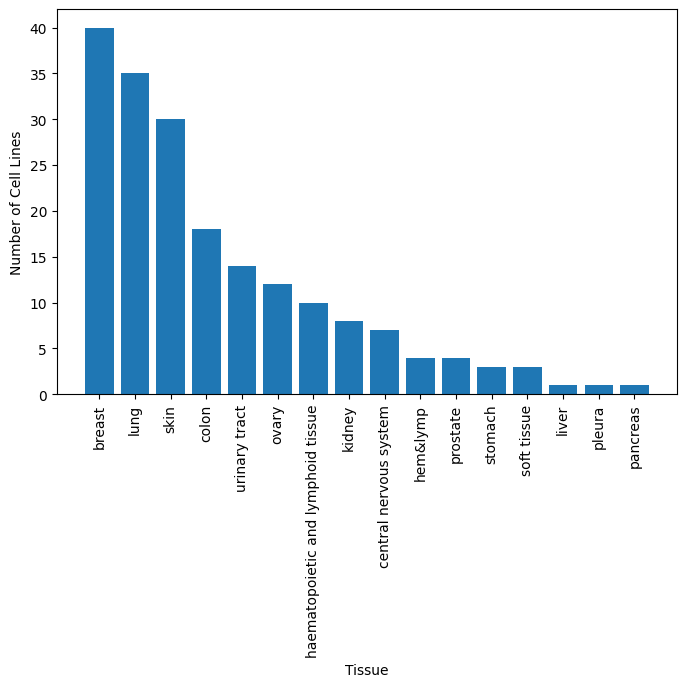

In [ ]:
tissue_cell_cnts = cell_line_tissue.groupby('tissue_id').count().sort_values(by='disease_id', ascending=False)['disease_id']

# Create a figure and axis for the plot
plt.figure(figsize=(8, 5))

# Generate the plot with numerical x-values
plt.bar(range(len(tissue_cell_cnts)), tissue_cell_cnts)  # Use numerical indices as x-values

# Set the x-tick labels to the corresponding tissue names, rotating them for better visibility
plt.xticks(range(len(tissue_cell_cnts)), [codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_cell_cnts.index], rotation=90)

# Set the labels for the axes
plt.xlabel('Tissue')
plt.ylabel('Number of Cell Lines')

# Optionally, save the figure
# plt.savefig(data_path + 'tissue_num_cell.png', bbox_inches='tight', dpi=200)

# Show the plot
plt.show()

## Data Preprocessing (5)
### **Cell line's gene expression**

Cell lines are also a part of this project and we will synthesis two datasets. This first dataset is CCLE and can be found here:
https://depmap.org/portal/download/all/

The second dataset used is called COSMIC and can be found here:
https://cancer.sanger.ac.uk/cosmic/download/cosmic


In [ ]:
#Mapping
gene_identifiers=pd.read_csv(external_data_path+'genetic_features/cell/gene_identifiers_latest.csv')
cell_line_meta = pd.read_csv(external_data_path+'genetic_features/cell/cell_line_meta.csv')

_codes={}
_codes['gene_id2hgnc_symbol']=gene_identifiers[['gene_id', 'hgnc_symbol']].set_index('gene_id').to_dict('index')
_codes['SANGAR_ID2cell_name']=cell_line_meta.loc[cell_line_meta['name'].isin(codes['cell'].idx2item) & ~cell_line_meta['SANGAR_ID'].isna(), ['SANGAR_ID', 'name']].set_index('SANGAR_ID').to_dict('index')
#Broad institute
fpkm_broad=pd.read_csv(external_data_path+'genetic_features/cell/fpkm_broad.csv')

fpkm_broad=fpkm_broad.loc[fpkm_broad['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_broad['model_id']=fpkm_broad['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_broad.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_broad.columns[1:]}, inplace=True)

fpkm_broad.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_broad.set_index('cell_id', inplace=True)
(fpkm_broad.sum()>0).sum()

23573

In [ ]:
#Sangar
fpkm_sangar=pd.read_csv(external_data_path+'genetic_features/cell/fpkm_sangar.csv')

fpkm_sangar=fpkm_sangar.loc[fpkm_sangar['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_sangar['model_id']=fpkm_sangar['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_sangar.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_sangar.columns[1:]}, inplace=True)

fpkm_sangar.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_sangar.set_index('cell_id', inplace=True)
(fpkm_sangar.sum()>0).sum()

19446

In [ ]:
cell_gene_fpkm= pd.concat([fpkm_broad,fpkm_sangar], sort=True) #integrate BROAD and SANGAR
cell_gene_fpkm=cell_gene_fpkm.loc[:,(cell_gene_fpkm.std(skipna=True)!=0)] #drop genes with std=0
cell_gene_fpkm.fillna(0, inplace=True)

cell_gene_fpkm_norm=((cell_gene_fpkm-cell_gene_fpkm.mean())/cell_gene_fpkm.std()) #z-score, gene-wise

unique_genes_cell = cell_gene_fpkm_norm.columns.to_list()
len(unique_genes_cell)

<ipython-input-75-01031cc330b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_gene_fpkm.fillna(0, inplace=True)


24268

### **Integrate all genes and save pickles**


In [ ]:
codes['gene']=Mapping(set(unique_genes_cell).union(set(unique_genes_drug)))
#number of unique genes
len(codes['gene'].idx2item)

25979

In [ ]:
#Update drug's genes
drug['gene_id']=drug['gene'].apply(lambda genes: [codes['gene'].item2idx[gene] for gene in genes])
#subset of drug features
drug[['id', 'smiles', 'fps', 'gene_id']].groupby('id').first().to_pickle(data_path+'drug_features.p')
#Merge cell line's tissue, disease type with gene_id
cell_gene = cell_gene_fpkm_norm.apply(lambda row: {codes['gene'].item2idx[gene]:row[gene] for gene in cell_gene_fpkm_norm.columns}, axis=1).reset_index()
cell_gene.rename(columns={0:'gene_id'}, inplace=True)
cell_gene=cell_gene.groupby('cell_id').first()
cell_line = pd.merge(cell_line_tissue, cell_gene, how='left', on='cell_id')
cell_line['gene_id']=cell_line['gene_id'].apply(lambda x: {} if type(x) is float else x)

cell_line.to_pickle(data_path+'cell_features.p')

In [ ]:
pickle.dump(codes, open(data_path+'codes.p', 'wb'))


### **Data exploratory analysis for cell lines**

In [ ]:
#Add cell line's tissue info into summary
summary_mean['tissue'] = summary_mean['cell_line_name'].apply(
    lambda x: cell_line_tissue.loc[x, 'tissue_id'] if x in cell_line_tissue.index else None
)

Text(0, 0.5, 'number of blocks')

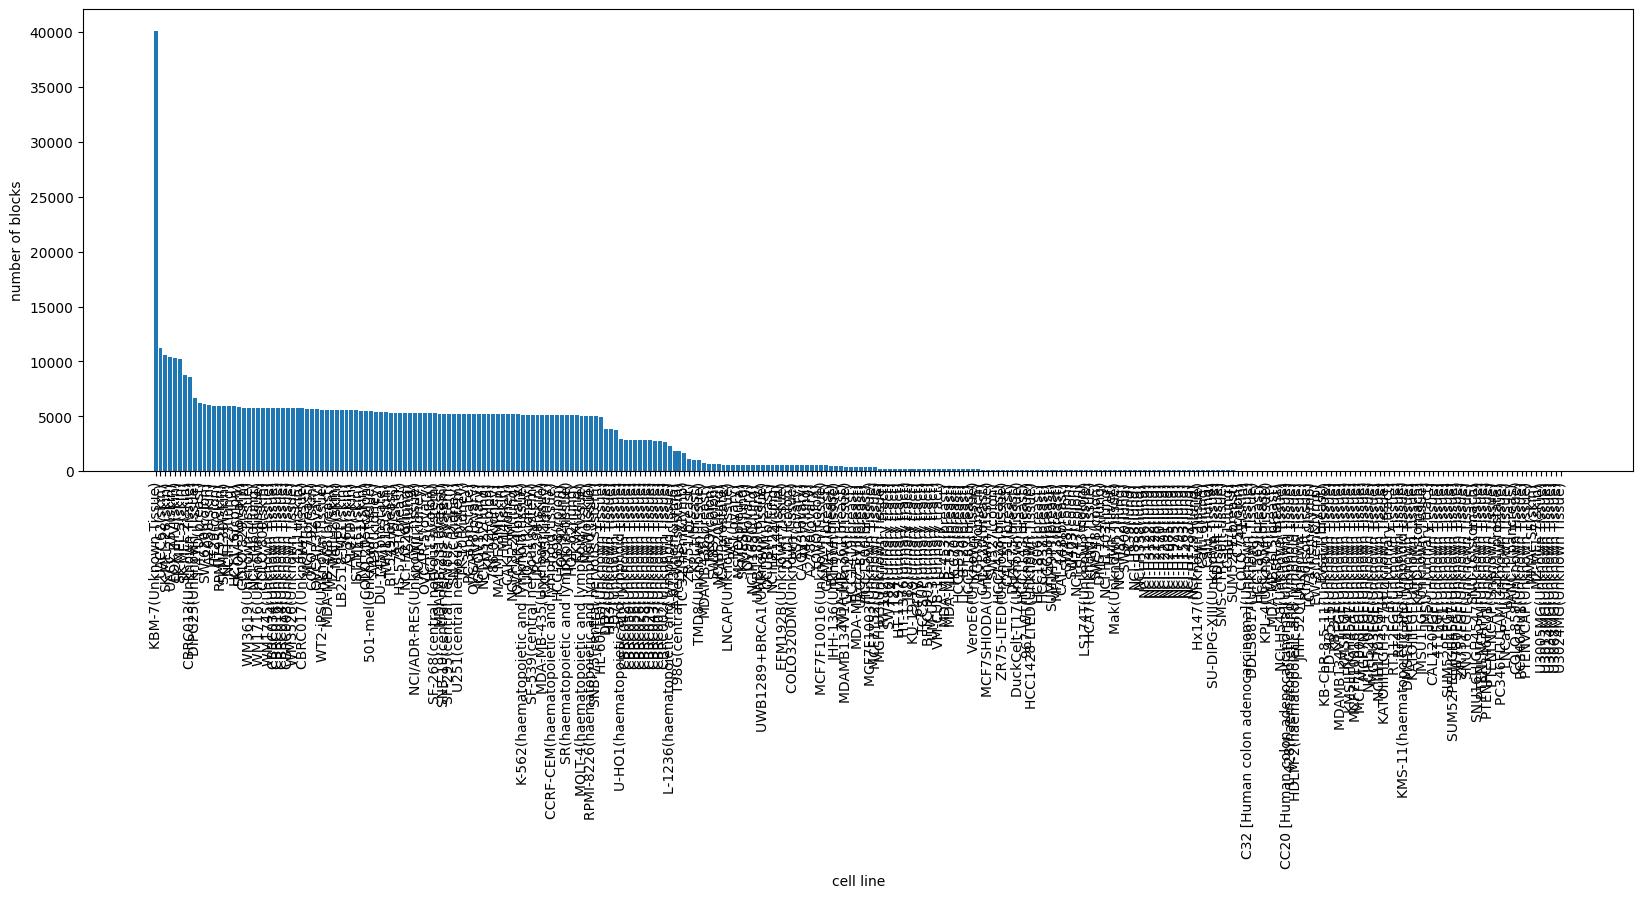

In [ ]:
plt.figure(figsize=(20,6))
# Prepare labels and handle missing cell_id or tissue_id
bar_labels = []
for cell_id in cell_line_exp.index:
    cell_label = codes['cell'].idx2item[cell_id] if cell_id < len(codes['cell'].idx2item) else 'Unknown Cell'
    if cell_id in cell_line_tissue.index and cell_line_tissue.loc[cell_id, 'tissue_id'] < len(codes['tissue'].idx2item):
        tissue_id = cell_line_tissue.loc[cell_id, 'tissue_id']
        tissue_label = codes['tissue'].idx2item[tissue_id]
    else:
        tissue_label = 'Unknown Tissue'
    bar_labels.append(f"{cell_label}({tissue_label})")

plt.bar(bar_labels, cell_line_exp)
plt.xticks(rotation=90)
plt.xlabel('cell line')
plt.ylabel('number of blocks')


Text(0, 0.5, 'number of drug combinations')

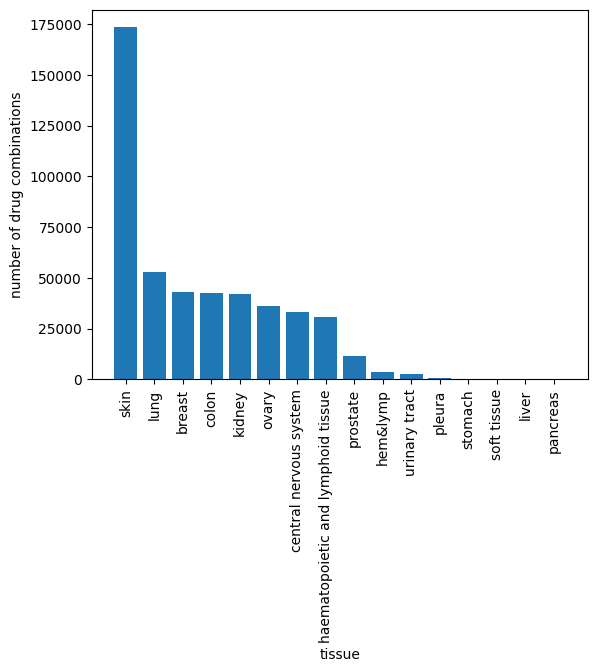

In [ ]:
tissue_exp=summary_mean.groupby('tissue').count()['drug_row'].sort_values(ascending=False)

plt.bar([codes['tissue'].idx2item[int(tissue_id)] for tissue_id in tissue_exp.index], tissue_exp)
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of drug combinations')
#plt.savefig(data_path+'tissue_num_comb.png', bbox_inches='tight', dpi=200)



In [ ]:
study_ids=['', 'ONEIL','CLOUD','ALMANAC','FORCINA','NCATS_ATL','Mathews','NCATS_DIPG','NCATS_ES(FAKi/AURKi)','NCATS_ES(Nampt+PARP)','Wilson','NCATS_HL','Yohe','NCATS_2D_3D','Phelan','NCATS_MDR_CS','CCLE','CTRPv2','FIMM','gCSI','GDSC1','GRAY','UHNBreast','BEATAML'] #from study.csv
num_blocks=summary_mean.groupby(['study_id', 'tissue'], as_index=False)['drug_row'].count().rename(columns={'drug_row':'num_blocks'})
num_blocks['tissue']=num_blocks['tissue'].apply(lambda x: codes['tissue'].idx2item[int(x)])

num_blocks['study_id'] = num_blocks['study_id'].apply(
    lambda x: study_ids[int(x)] if int(x) < len(study_ids) and int(x) >= 0 else 'Unknown Study'
)

num_blocks_pivot = num_blocks.pivot_table(
    index='study_id',
    columns='tissue',
    values='num_blocks',
    aggfunc='sum'
).fillna(0)
study_ids = ['ALMANAC', 'CLOUD', 'NCATS_HL', 'FORCINA', 'Mathews', 'Wilson', 'Yohe', 'NCATS_MDR_CS', 'Phelan', 'NCATS_ATL', 'NCATS_2D_3D',
             'NCATS_DIPG', 'NCATS_ES(FAKi/AURKi)', 'NCATS_ES(Nampt+PARP)', 'ONEIL']
tissues = ['brain', 'breast', 'colon', 'endometrium', 'hem&lymp', 'kidney', 'lung', 'ovary', 'bone', 'prostate']
num_blocks_pivot = num_blocks_pivot.reindex(index=study_ids, columns=tissues).fillna(0)


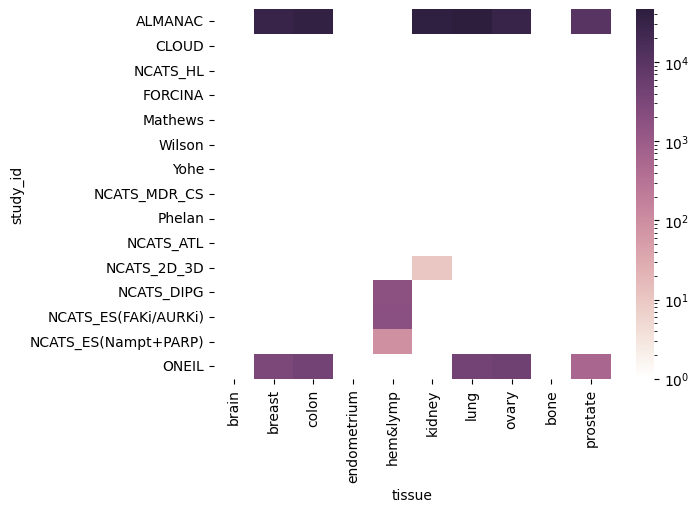

In [ ]:
log_norm=LogNorm(vmin=num_blocks_pivot.min().min()+1, vmax=num_blocks_pivot.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(num_blocks_pivot.min().min()+1)), 1+math.ceil(math.log10(num_blocks_pivot.max().max())))]

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

ax=sns.heatmap(num_blocks_pivot.replace(0,1),
           norm=log_norm,
            cbar_kws={'ticks':cbar_ticks},
            cmap=cmap)

#fig=ax.get_figure()
#fig.tight_layout()
#fig.savefig(data_path+'study_heatmap.png', dpi=200)

Text(0, 0.5, 'number of unique drugs')

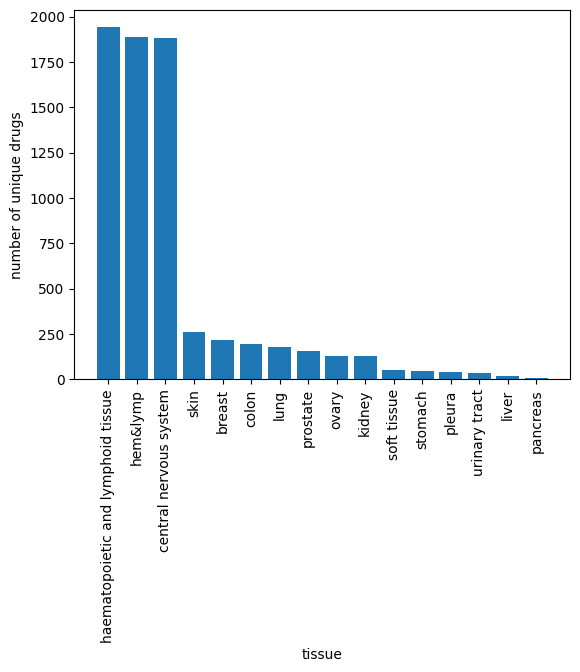

In [ ]:
#list unique drugs per tissue
tissue_drugs = pd.merge(summary_mean.groupby('tissue')['drug_row'].apply(set).reset_index(name='drug_row'),
         summary_mean.groupby('tissue')['drug_col'].apply(set).reset_index(name='drug_row'),
         on='tissue')
tissue_drugs['drugs']=tissue_drugs.apply(lambda row: row[1].union(row[2]), axis=1)
tissue_drugs.drop(['drug_row_x','drug_row_y'], axis=1, inplace=True)
tissue_drugs['num_drugs']=tissue_drugs['drugs'].apply(lambda x: len(x))
tissue_drugs.sort_values('num_drugs', ascending=False, inplace=True)
plt.bar([codes['tissue'].idx2item[int(tissue_id)] for tissue_id in tissue_drugs['tissue']], tissue_drugs['num_drugs'])
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of unique drugs')
#plt.savefig(data_path+'tissue_num_drugs.png', bbox_inches='tight', dpi=200)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

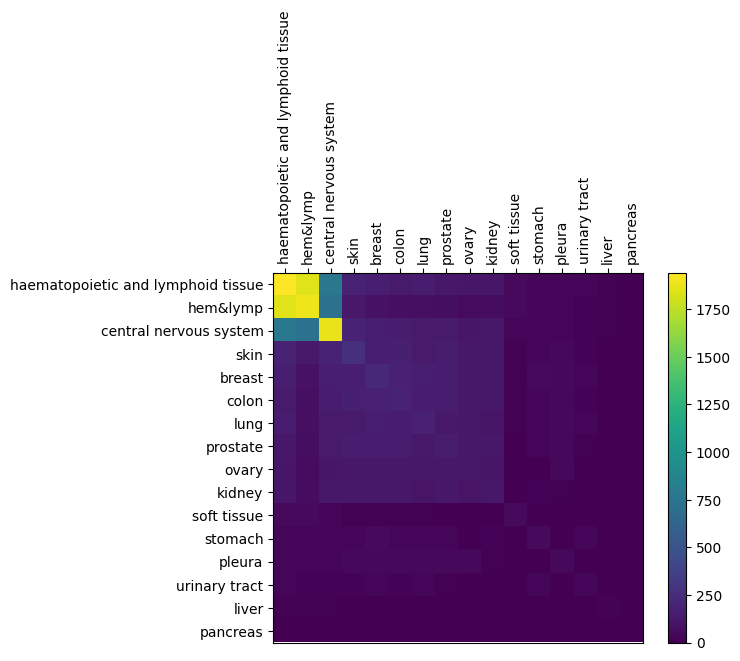

In [ ]:
num_intersects=np.zeros((len(tissue_drugs),len(tissue_drugs)))
for i, tissue_id in enumerate(tissue_drugs['tissue']):
    num_intersects[i,:]=tissue_drugs['drugs'].apply(lambda x: len(x.intersection(tissue_drugs.loc[tissue_id, 'drugs']))).values


fig,ax=plt.subplots()
im=ax.imshow(num_intersects)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(np.arange(len(tissue_drugs)))
ax.set_yticks(np.arange(len(tissue_drugs)))
ax.set_xticklabels([codes['tissue'].idx2item[int(tissue_id)] for tissue_id in tissue_drugs['tissue']])
ax.set_yticklabels([codes['tissue'].idx2item[int(tissue_id)] for tissue_id in tissue_drugs['tissue']])

fig.colorbar(im, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=90)
#fig.tight_layout()
#plt.savefig(data_path+'heatmap.png', bb_inches='tight', dpi=200)

#Model Building

This section will go over the implementation of the model

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import pdb
import time
import pickle
import logging
import matplotlib.pyplot as plt
from utilities import Mapping


import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
data_path=''
save_path=''

bsz=128
cuda=True
device=3
torch.cuda.set_device(device)

num_gene_compressed_drug=64
num_gene_compressed_cell=128

#isClassification=True #False for regression task
syn_threshold=30
ri_threshold=50

log_interval=100
epochs=10

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

##Load data


In [ ]:
#drug pair, cell, scoers
df=pickle.load(open(data_path+'summary_mean.p', 'rb'))
codes=pickle.load(open(data_path+'codes.p', 'rb'))

In [ ]:
df.head()


,drug_row,drug_col,cell_line_name,study_id,study_name,tissue_name,ri_row,ri_col,synergy_loewe
0,367,3900,0,4,FORCINA,brain,-21.079400,17.392589,4.436431
1,3365,323,1,6,MATHEWS,haematopoietic_and_lymphoid,-20.043000,25.595000,-44.555935
2,3365,1798,1,6,MATHEWS,haematopoietic_and_lymphoid,-9.776000,29.111000,-37.189720
3,3622,3900,0,4,FORCINA,brain,-4.051616,17.392589,10.755529
4,2166,464,2,8,NCATS_ES(FAKI/AURKI),bone,1.966000,25.537000,-8.644502


In [ ]:
# Drug's external features
drug_features=pickle.load(open(data_path+'drug_features.p', 'rb'))

In [ ]:
# Cell's external features
cell_features=pickle.load(open(data_path+'cell_features.p', 'rb'))

In [ ]:
num_celllines= len(codes['cell'].idx2item)
num_drugs=len(codes['drugs'].idx2item)

num_genes = len(codes['gene'].idx2item)
num_tissue = len(codes['tissue'].idx2item)
num_disease = len(codes['disease'].idx2item)

num_drug_fp=len(drug_features.loc[0,'fps'])
max_drug_sm_len = drug_features['smiles'].apply(lambda x: len(x)).max()

#Gene compression
This section will go over the dataloaders that cover the cell lines compression for the model training and the dataloaders that cover the drug target compression.

##Dataset and Dataloader

In [ ]:
class DrugTargetDataset(Dataset):
    def __init__(self, drug_features):
        self.drug_features = drug_features
    def __len__(self):
        return len(self.drug_features)
    def __getitem__(self,idx):
        gene_ids=self.drug_features.loc[idx, 'gene_id']
        genes=np.zeros(num_genes)
        genes[gene_ids]=1

        return genes

class CellGeneDataset(Dataset):
    def __init__(self, cell_features):
        self.cell_features = cell_features
    def __len__(self):
        return len(self.cell_features)
    def __getitem__(self,idx):
        gene_ids=self.cell_features.loc[idx,'gene_id']
        genes = np.zeros(num_genes)
        for key,value in gene_ids.items():
            genes[key]=value

        return genes


In [ ]:
#Two layers of fully connected layers
class FC2(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super(FC2, self).__init__()

        self.bn = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features, int(in_features/2))
        self.fc2 = nn.Linear(int(in_features/2),out_features)
        self.dropout= nn.Dropout(dropout)

    def forward(self, x):
        x = self.bn(x)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

##Compress gene features
Here is where the compression happens. For cell lines COSMIC and CCLE are combined.

For drug targets, DrugBank, NIH-LINC, and TTD are combined.

In [ ]:
class GeneCompressor(nn.Module):
    def __init__(self, num_in, num_out, dropout=0.1):
        super(GeneCompressor, self).__init__()
        self.dropout=dropout
        self.encoder=nn.Linear(num_in, num_out)
        self.decoder=nn.Linear(num_out,num_in)

    def _encoder(self,x):
        return F.dropout(F.relu(self.encoder(x)), self.dropout, training=self.training)

    def _decoder(self,x):
        return F.dropout(self.decoder(x), self.dropout, training=self.training)

    def forward(self, x):
        x=self._encoder(x)
        x=self._decoder(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
def geneCompressing(data_loader,num_gene_compressed, noise_weight=0.2, epochs=20, log_interval=10 ):
    #model
    geneCompressor=GeneCompressor(num_genes, num_out=num_gene_compressed, dropout=0.1)
    if cuda:
        geneCompressor=geneCompressor.cuda()
    criterion=nn.MSELoss()
    optimizer=optim.Adam(geneCompressor.parameters())

    for epoch in range(1,epochs+1):
        #train
        geneCompressor.train()
        total_loss=0
        start_time=time.time()
        for iteration, gene in enumerate(data_loader):
            gene=Variable(gene).float()
            noise=noise_weight*torch.randn(gene.shape)

            if cuda:
                gene=gene.cuda()
                noise=noise.cuda()
            optimizer.zero_grad()
            output=geneCompressor(gene+noise)
            loss=criterion(output,gene)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            if iteration % log_interval == 0 and iteration > 0:
                cur_loss = total_loss.item() / log_interval
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(data_loader)/bsz), elapsed * 1000/log_interval, cur_loss))
                total_loss = 0
                start_time = time.time()
#         #test
#         geneCompressor.eval()
#         total_loss=0
#         start_time=time.time()
#         with torch.no_grad():
#             for iteration, gene in enumerate(test_data_loader):
#                 gene=Variable(gene).float()
#                 if cuda:
#                     gene=gene.cuda(device)
#                 output=geneCompressor(gene)
#                 loss=criterion(output,gene)
#                 total_loss += loss.data
#             print(total_loss.item()/iteration)
    return geneCompressor

In [ ]:
import torch
print(torch.cuda.is_available())
#drug's target gene data
drugGeneDataset=DrugTargetDataset(drug_features)
drugGeneDataset_loader = DataLoader(drugGeneDataset, batch_size=64, shuffle=True)
#learn
drugGeneCompressor=geneCompressing(drugGeneDataset_loader, num_gene_compressed_drug)
#save
drugGeneCompressor.eval()
drugGeneCompressed=np.array([drugGeneCompressor.cpu()._encoder(torch.FloatTensor(drugGeneDataset[d])).data.numpy() for d in range(num_drugs)])
torch.save(drugGeneCompressor.state_dict(), data_path+'drugGeneCompressor.p')
pickle.dump(drugGeneCompressed, open(data_path+'drugGeneCompressed.p', 'wb'))

In [ ]:

drugGeneCompressed=pickle.load(open(data_path+'drugGeneCompressed.p', 'rb'))
drugGeneCompressed=torch.FloatTensor(drugGeneCompressed)

In [ ]:
#cell line's gene expression data
cellGeneDataset=CellGeneDataset(cell_features)
cellGeneDataset_loader = DataLoader(cellGeneDataset, batch_size=64, shuffle=True)
#learn
cellGeneCompressor=geneCompressing(cellGeneDataset_loader,num_gene_compressed_cell, noise_weight=0.01, log_interval=1 )
#save
cellGeneCompressor.eval()
cellGeneCompressed=np.array([cellGeneCompressor.cpu()._encoder(torch.FloatTensor(cellGeneDataset[d])).data.numpy() for d in range(num_celllines)])
torch.save(cellGeneCompressor.state_dict(), data_path+'cellGeneCompressor.p')
pickle.dump(cellGeneCompressed, open(data_path+'cellGeneCompressed.p', 'wb'))

In [ ]:
cellGeneCompressed=pickle.load(open(data_path+'cellGeneCompressed.p', 'rb'))
cellGeneCompressed=torch.FloatTensor(cellGeneCompressed)

#Synergy prediction

Here is where the train test splits are created for the model training and evalutation.


##Train/test split in cross or external validation

In [ ]:
def get_cell_of_interest(tissues):
    tissues_of_interests = [codes['tissue'].item2idx[minor_tissue] for minor_tissue in tissues]
    cell_of_interest = cell_features.index[cell_features['tissue_id'].isin(tissues_of_interests)].tolist()
    return cell_of_interest

Train/test for general model



In [ ]:
minor_tissues=['bone', 'prostate' ]
cell_of_interest = get_cell_of_interest(minor_tissues)
df_tissue_of_interest = df.loc[df['cell_line_name'].isin(cell_of_interest),:]
df_all = df.drop(df_tissue_of_interest.index)
#specific database
#df_all=df_all.loc[df_all['study_id']==3]
#cross validation
df_train, df_test = train_test_split(df_all, test_size=0.2) #cross validation
#external validation
#df_train=df_all.loc[df_all['study_id']==3] 3: 'ALMANAC'
#df_test=df_all.loc[df_all['study_id']==1] 1: 'ONEIL'

Train/test for bone



In [ ]:
_df_bone = df.loc[df['cell_line_name'].isin(get_cell_of_interest(['bone'])),:]
# Cross validation
_df_train_bone, _df_test_bone = train_test_split(_df_bone, test_size=0.2, random_state=1)
# External validation
#_df_train_bone=_df_bone.loc[_df_bone['study_id']!=9]
#_df_test_bone= _df_bone.loc[_df_bone['study_id']==9]

Train/test for prostate

In [ ]:
_df_prostate= df.loc[df['cell_line_name'].isin(get_cell_of_interest(['prostate'])),:]
#Cross validation
_df_train_prostate, _df_test_prostate = train_test_split(_df_prostate, test_size=0.2, random_state=1)
# External validation
#_df_train_prostate=_df_prostate.loc[_df_prostate['study_id']!=1]
#_df_test_prostate=_df_prostate.loc[_df_prostate['study_id']==1]

##Dataset and Dataloader


In [ ]:
class DrugCombDataset(Dataset):
    def __init__(self, df, drug_features, cell_features):
        self.df = df
        self.drug_features = drug_features
        self.cell_features = cell_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        d1 = self.df.iloc[idx, 0]
        d2 = self.df.iloc[idx, 1]
        cell = self.df.iloc[idx,2]
        ri_d1 = 1.0 if self.df.iloc[idx,3] >ri_threshold else 0
        ri_d2 = 1.0 if self.df.iloc[idx,4] >ri_threshold else 0
        syn = 1.0 if self.df.iloc[idx, 5] >syn_threshold else 0


        #external features
        d1_fp = np.array(self.drug_features.loc[d1, 'fps'])
        d1_sm = self.drug_features.loc[d1, 'smiles']
        d1_sm = np.pad(d1_sm, pad_width=(0, max_drug_sm_len-len(d1_sm)), mode='constant', constant_values=0)
        d1_gn=drugGeneCompressed[d1]

        d2_fp = np.array(self.drug_features.loc[d2, 'fps'])
        d2_sm = self.drug_features.loc[d2, 'smiles']
        d2_sm = np.pad(d2_sm, pad_width=(0, max_drug_sm_len-len(d2_sm)), mode='constant', constant_values=0)
        d2_gn=drugGeneCompressed[d2]

        c_ts = self.cell_features.loc[cell, 'tissue_id']
        c_ds = self.cell_features.loc[cell, 'disease_id']
        c_gn= cellGeneCompressed[cell]

        sample = {
            'd1': d1,
            'd1_fp': d1_fp,
            'd1_sm': d1_sm,
            'd1_gn': d1_gn,

            'd2': d2,
            'd2_fp': d2_fp,
            'd2_sm': d2_sm,
            'd2_gn': d2_gn,

            'cell': cell,
            'c_ts': c_ts,
            'c_ds': c_ds, #missing -1
            'c_gn': c_gn,

            'ri_d1': ri_d1,
            'ri_d2': ri_d2,
            'syn': syn
        }

        return sample

##Load dataset


General model



In [ ]:
train = DrugCombDataset(df_train, drug_features, cell_features)
train_loader = DataLoader(train, batch_size=bsz, shuffle=True )
test = DrugCombDataset(df_test, drug_features, cell_features)
test_loader = DataLoader(test, batch_size=bsz, shuffle=True )

Bone

In [ ]:
_train_bone = DrugCombDataset(_df_train_bone, drug_features, cell_features)
_train_loader_bone = DataLoader(_train_bone, batch_size=bsz, shuffle=True )
_test_bone = DrugCombDataset(_df_test_bone, drug_features, cell_features)
_test_loader_bone = DataLoader(_test_bone, batch_size=bsz, shuffle=False )

Prostate



In [ ]:
_train_prostate = DrugCombDataset(_df_train_prostate, drug_features, cell_features)
_train_loader_prostate = DataLoader(_train_prostate, batch_size=bsz, shuffle=True )
_test_prostate = DrugCombDataset(_df_test_prostate, drug_features, cell_features)
_test_loader_prostate = DataLoader(_test_prostate, batch_size=bsz, shuffle=False )

#Prediction model

Our main training model will be called Comb(). For Comb() to work we need to include 2 other encoder models. These are DrugEncoder() and CellEncoder().

DrugEncoder() loads from the the drug combined dataloader. The comments in the model go over how the model goes through the different parts of the input data in order to prep for the forward pass.

CellEncoder() is much the same but uses the cell lines combined dataloader.

Comb() is the main prediction model. It is made from the drug encoder and the cell encoder models. The forward pass encodes the initial drug, then the starting drug.

The synergy is calculated by concatentation the two drug encoders and also the cell line encoder and passing them through a fully connected layer. The sensitivities for each drug encoding is also calculated by passing them through a fully connected layer after concatentation.

In [ ]:
class DrugEncoder(nn.Module):
    def __init__(self,
                 num_drugs=num_drugs,
                 num_ID_emb=0,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                 num_gene = num_gene_compressed_drug,
                 num_comp_char=len(codes['mole'].idx2item),
                 fp_embed_sz = 32,
                 gene_embed_sz = int(num_gene_compressed_drug/2),
                 out_size=64,
                 dropout=0.3):
        super(DrugEncoder, self).__init__()

        self.dropout= dropout
        #DRUG
        #drug ID
        #self.embed_id = nn.Embedding(num_drugs, num_ID_emb)

        #compound ID
        self.embed_comp = nn.Embedding(num_comp_char, num_comp_char, padding_idx=0)#padding's idx=0
        #encoding compound
        self.encoderlayer = nn.TransformerEncoderLayer(d_model=num_comp_char, nhead=4)
        self.encoder = nn.TransformerEncoder(self.encoderlayer, num_layers=1)

        #fingerprint
        self.dense_fp = nn.Linear(num_drug_fp,fp_embed_sz)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)

        #depthwise for compound encoding
        self.conv = nn.Conv2d(1, 1, (1, num_comp_char), groups=1)

        #combined
        combined_sz = num_ID_emb+fp_embed_sz+max_drug_sm_len+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)

    def forward(self, d_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, fp, sm, gn = d_list

        sm = self.embed_comp(sm) #bsz*max_drug_sm_len*num_comp_char(embedding size)
        sm = self.encoder(sm)
        sm = self.conv(sm.unsqueeze(1)).squeeze()

        fp = F.relu(self.dense_fp(fp))
        gn = F.relu(self.dense_gene(gn))

        #combine
        x = torch.cat((fp, sm, gn),1) # bsz*[num_emb_id+num_drug_fp+max+drug_sm]
        x = self.FC2(x)

        return x


In [ ]:
class CellEncoder(nn.Module):
    def __init__(self,
                 num_cells=num_celllines,
                 num_tissue=0,
                 num_disease=num_disease,
                 num_ID_emb=0,
                 gene_embed_sz=int(num_gene_compressed_cell/2),
                 num_gene=num_gene_compressed_cell,
                 out_size=64,
                 dropout=0.3):
        super(CellEncoder, self).__init__()

        self.dropout= dropout
        #cell ID
        #self.embed_id = nn.Embedding(num_cells, num_ID_emb)
        #cell tissue
        #self.embed_ts = nn.Embedding(num_tissue, num_tissue)
        #cell disease
        self.embed_ds = nn.Embedding(num_disease, num_disease, padding_idx=3)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)

        #combined
        combined_sz = num_ID_emb+num_tissue+num_disease+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)


    def forward(self, c_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, ts, ds, gn = c_list
        ds = F.relu(self.embed_ds(ds)) #bsz*num_diesaes

        gn = F.relu(self.dense_gene(gn)) #bsz*gene_embed_sz

        #combine
        x = torch.cat((ds, gn),1) # bsz*combined_sz
        x = self.FC2(x)

        return x

In [ ]:
class Comb(nn.Module):
    def __init__(self, num_cells=num_celllines,
                 num_drugs=num_drugs,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                num_comp_char=len(codes['mole'].idx2item),
                 num_ID_emb=0,
                 out_size=64,
                dropout=0.3):

        super(Comb, self).__init__()

        self.dropout=dropout
        #drug
        self.drugEncoder = DrugEncoder()
        #cell
        self.cellEncoder = CellEncoder()
        #fc
        self.fc_syn = FC2(out_size*3, 1, dropout)
        self.fc_ri = FC2(out_size*2, 1, dropout)

    def forward(self, d1_list, d2_list, c_list):
        d1 = self.drugEncoder(d1_list)
        d2 = self.drugEncoder(d2_list)
        c = self.cellEncoder(c_list)

        syn = self.fc_syn(torch.cat((d1, d2, c),1))
        ri1 = self.fc_ri(torch.cat((d1,c),1))
        ri2 = self.fc_ri(torch.cat((d2,c),1))

        return syn, ri1, ri2

#Training

The model training is as follows. We take our Comb() model and begin training with a Binary Cross Entropy Loss. We use the Adagrad optimizer.

For training we get all the training sample values from the training data loader and then we pass them into the model. The drug synergy is outputted by the model and we compute loss, compute the gradient, and iterate the model.


In [ ]:
model = Comb()
if cuda:
    model = model.cuda()
#Regression
#criterion_mse = nn.MSELoss()
#Classification
criterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(model.parameters())

In [ ]:
#Training
def training(isAux, data_loader):
    model.train()
    total_loss = 0
    start_time = time.time()

    for iteration, sample in enumerate(data_loader):
        d1=Variable(sample['d1'])
        d1_fp = Variable(sample['d1_fp'].float())
        d1_sm = Variable(sample['d1_sm'])
        d1_gn = Variable(sample['d1_gn'].float())

        d2=Variable(sample['d2'])
        d2_fp = Variable(sample['d2_fp'].float())
        d2_sm = Variable(sample['d2_sm'])
        d2_gn = Variable(sample['d2_gn'].float())

        cell = Variable(sample['cell'])
        c_ts = Variable(sample['c_ts'])
        c_ds = Variable(sample['c_ds'])
        c_gn = Variable(sample['c_gn'].float())

        syn_true = Variable(sample['syn'].float())
        ri_d1=Variable(sample['ri_d1'].float())
        ri_d2=Variable(sample['ri_d2'].float())


        if cuda:
            d1=d1.cuda()
            d1_fp=d1_fp.cuda()
            d1_sm=d1_sm.cuda()
            d1_gn=d1_gn.cuda()

            d2=d2.cuda()
            d2_fp=d2_fp.cuda()
            d2_sm=d2_sm.cuda()
            d2_gn=d2_gn.cuda()

            cell=cell.cuda()
            c_ts=c_ts.cuda()
            c_ds=c_ds.cuda()
            c_gn=c_gn.cuda()

            syn_true=syn_true.cuda()
            ri_d1=ri_d1.cuda()
            ri_d2=ri_d2.cuda()

        optimizer.zero_grad()

        syn, ri1, ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts, c_ds, c_gn) )

        if not isAux:
            loss = criterion_bce(syn, syn_true.view(-1,1))
        else:
            loss = criterion_bce(ri1, ri_d1.view(-1,1))+criterion_bce(ri2, ri_d2.view(-1,1))

        loss.backward()
        optimizer.step()
        total_loss += loss.data

        if iteration % log_interval == 0 and iteration > 0:
            cur_loss = total_loss.item() / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(train_loader)/bsz), elapsed * 1000/log_interval, cur_loss))

            total_loss = 0
            start_time = time.time()

In [ ]:

def evaluate(data_loader):
    model.eval()
    total_loss = 0
    total_loss_sen = 0


    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1=Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2=Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1=Variable(sample['ri_d1'].float())
            ri_d2=Variable(sample['ri_d2'].float())


            if cuda:
                d1=d1.cuda()
                d1_fp=d1_fp.cuda()
                d1_sm=d1_sm.cuda()
                d1_gn=d1_gn.cuda()

                d2=d2.cuda()
                d2_fp=d2_fp.cuda()
                d2_sm=d2_sm.cuda()
                d2_gn=d2_gn.cuda()

                cell=cell.cuda()
                c_ts=c_ts.cuda()
                c_ds=c_ds.cuda()
                c_gn=c_gn.cuda()

                syn_true=syn_true.cuda()
                ri_d1=ri_d1.cuda()
                ri_d2=ri_d2.cuda()


            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )
            loss = criterion_bce(syn, syn_true.view(-1,1))
            total_loss +=loss.data
            loss_sen = (criterion_bce(ri1, ri_d1.view(-1,1))+criterion_bce(ri2, ri_d2.view(-1,1)))/2
            total_loss_sen += loss_sen.data

        print('syn mse', total_loss.item()/(iteration+1))
        print('sen_mse', total_loss_sen.item()/(iteration+1))

In [ ]:

best_val_loss = None
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        training(False, train_loader)
        training(True, train_loader)
        evaluate(test_loader)
        print('-'*89)
except KeyboardInterrupt:
    print('-'*89)
    print('Existing from training early')

#Evaluate the general model
The model is evaluated based on a few metrics the original paper uses the metrics as: AUROC, AUPRC, MSE

The original paper achieved these results:

{0.9577 AUROC, 0.8335 AUPRC, 132.4 MSE} Cross Validation

{0.6376 AUROC, 0.5564 AUPRC, 742.1 MSE} External Validation

Our implementation for this project will aim to hit these metrics. Any ablations we will also aim to hit these metrics.

In [ ]:
def dcg_score(y_score, y_true, k):
    """
        https://www.kaggle.com/davidgasquez/ndcg-scorer
        y_true: np.array, size= [n_samples]
        y_score: np.array, size=[n_samples]
        k: int, rank
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    #gain = 2 ** y_true -1
    gain = y_true

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain/discounts)

def evaluate_accuracy(data_loader):
    model.eval()

    syn_all=[]
    syn_true_all=[]
    ri1_all=[]
    ri1_true_all=[]
    ri2_all=[]
    ri2_true_all=[]

    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1=Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2=Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1=Variable(sample['ri_d1'])
            ri_d2=Variable(sample['ri_d2'])

            if cuda:
                d1=d1.cuda()
                d1_fp=d1_fp.cuda()
                d1_sm=d1_sm.cuda()
                d1_gn=d1_gn.cuda()

                d2=d2.cuda()
                d2_fp=d2_fp.cuda()
                d2_sm=d2_sm.cuda()
                d2_gn=d2_gn.cuda()

                cell=cell.cuda()
                c_ts=c_ts.cuda()
                c_ds=c_ds.cuda()
                c_gn=c_gn.cuda()


            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )

            syn_all.append(syn.data.cpu().numpy())
            syn_true_all.append(syn_true.numpy())

            ri1_all.append(ri1.data.cpu().numpy())
            ri1_true_all.append(ri_d1.numpy())

            ri2_all.append(ri2.data.cpu().numpy())
            ri2_true_all.append(ri_d2.numpy())

    return syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all

Evaluate synergy prediction



In [ ]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all= evaluate_accuracy(test_loader)

syn_all= [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]
#NDCG
dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20)
#AUPRC
metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

Evaluate sensitivity prediction



In [ ]:

ri1_all= [r.item() for ri in ri1_all for r in ri]
ri1_true_all = [r for ri in ri1_true_all for r in ri]

ri2_all= [r.item() for ri in ri2_all for r in ri]
ri2_true_all = [r for ri in ri2_true_all for r in ri]

ri_all=ri1_all+ri2_all
ri_true_all=ri1_true_all+ri2_true_all
#NDCG
dcg_score(ri_all,ri_true_all, k=20)/dcg_score(ri_true_all,ri_true_all, k=20)
#AUC
metrics.roc_auc_score(ri_true_all,  1/(1 + np.exp(-np.array(ri_all))))

#Transfer the general model to specific model


If you want to boost a bit more with general model's test set



In [ ]:
#Use major's test set
training(False, test_loader)
training(True, test_loader)

##Freeze layers

Examine the layer's ID that we'd like to fix or free

In [ ]:
for i, param in enumerate(model.parameters()):
    print(i, param.size(), param.requires_grad)
release_after = 46
for i, param in enumerate(model.parameters()):
    if i>=release_after:
        param.requires_grad=True
    else:
        param.requires_grad=False

Prostate or bone



In [ ]:
_train_loader_minor=_train_loader_prostate
_test_loader_minor=_test_loader_prostate
_test_minor=_test_prostate
#_train_loader_minor=_train_loader_bone
#_test_loader_minor=_test_loader_bone
#_test_minor=_test_bone
#Use minor's train set
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        training(False, _train_loader_minor)
        training(True, _train_loader_minor)
        evaluate(_test_loader_minor)
        print('-'*89)
except KeyboardInterrupt:
    print('-'*89)
    print('Existing from training early')

Evaluate synergy prediction



In [ ]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all= evaluate_accuracy(_test_loader_minor)

syn_all= [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]
#NDCG
dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20)
#AUROC
metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUPRC
metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

Evaluate sensitivity prediction



In [ ]:
ri1_all= [r.item() for ri in ri1_all for r in ri]
ri1_true_all = [r for ri in ri1_true_all for r in ri]

ri2_all= [r.item() for ri in ri2_all for r in ri]
ri2_true_all = [r for ri in ri2_true_all for r in ri]

ri_all=ri1_all+ri2_all
ri_true_all=ri1_true_all+ri2_true_all
#NDCG
dcg_score(ri_all,ri_true_all, k=20)/dcg_score(ri_true_all,ri_true_all, k=20)
#AUC
metrics.roc_auc_score(ri_true_all,  1/(1 + np.exp(-np.array(ri_all))))

#Select the top ranked drug combinations


In [ ]:
syn_all_prob=1/(1 + np.exp(-np.array(syn_all)))
order = np.argsort(syn_all_prob)[::-1]
syn_true_all_order = np.take(syn_true_all, order[:20])
for k in range(20):
    comb=_test_minor[order[k]]
    print(codes['drugs'].idx2item[comb['d1']], ',',
          codes['drugs'].idx2item[comb['d2']], ',',
          codes['cell'].idx2item[comb['cell']],  ',',
          codes['tissue'].idx2item[comb['c_ts']],  ',',
          codes['disease'].idx2item[comb['c_ds']], ',',
          comb['ri_d1'], ',',
          comb['ri_d2'], ',',
          syn_true_all_order[k])

# Results

This section will go over the results of the project in comparison to the results of the paper and.

For the Draft we were not able to get results from the model. This is due to data collection error and then data cleaning errors. We were able to get much of preprocess down but there are some lingering problems that prevent us from running through the models. We had to reach out to the author of the paper who kindly provided datasets for us to use, but we needed more time once we had proper data to figure out these issues.

Analysis is not present as well because of the aforementioned reasons.

We have ablations planned for the model.

1) We plan to remove the dropout layer for the model. We believe that over-fitting is not necessarily possible with this scenario as this model can be trained and targeted to different forms of human body tissue. Therefore we do not need to worry about this being a general model in totality, we can tailor it to one tissue at a time.

2) We also want to remove the 2nd drug encoder sensitvity segment of the forward pass. This is about determining the effectiveness of one drug on the other so therefore we want to see if we remove this segement, will the model perform. If it does perform well we want to figure out what that says for the actual model results.

#References

1.   Jaeger, S., Duran-Frigola, M. & Aloy, P. Drug sensitivity in cancer cell lines is not tissue-specific.
Mol Cancer 14, 40 (2015).
https://doi-org.proxy2.library.illinois.edu/10.1186/s12943-015-0312-6
2.   Kim, Y., Zheng, S., Tang, J., Jim Zheng, W., Li, Z., & Jiang, X. (2021). Anticancer drug synergy
prediction in understudied tissues using transfer learning. Journal of the American
Medical Informatics Association : JAMIA, 28(1), 42–51.
https://doi.org/10.1093/jamia/ocaa212
3. Yao F, Madani Tonekaboni SA, Safikhani Z, Smirnov P, El-Hachem N, Freeman M, Manem VSK,
Haibe-Kains B. Tissue specificity of in vitro drug sensitivity. J Am Med Inform Assoc.
2018 Feb 1;25(2):158-166. doi: 10.1093/jamia/ocx062. PMID: 29016819; PMCID:
PMC6381764.
4. Zheng, S., Aldahdooh, J., Shadbahr, T., Wang, Y., Aldahdooh, D., Bao, J., Wang, W., & Tang, J.
(2021). Drugcomb update: A more comprehensive drug sensitivity data repository and
Analysis Portal. Nucleic Acids Research, 49(W1). https://doi.org/10.1093/nar/gkab438
5. Kim, Y. (2024). Genetic Features, https://drive.google.com/drive/folders/1ORFe0hw_oVCjnkJupji6ah2HwJGzSe3E?usp=sharing